In [1]:
from pySnowRadar.processing import geo_filter, batch_process
from glob import glob
import matplotlib.pyplot as plt

In [2]:
print(geo_filter.__doc__)


    Given a list of SnowRadar datafiles (.mat, .h5, .nc), filter out
    any files whose bounding geometry intersect with land

    Landmask is based on NaturalEarth 1:10m Cultural v4.1.0 (Canada, Greenland, and USA)
    http://www.naturalearthdata.com/

    Arguments:
        input_sr_data: list of supported SnowRadar data files

    Output:
        subset of input_sr_data where no land intersections occur
    


In [3]:
print(batch_process.__doc__)


    For a given list of SnowRadar data file paths:
        1) Pick air-snow and snow-ice interface layers for the 
           data files using the provided picker and snow density

        2) Produce a dataframe with the all the picked interfaces for each 
           of the data files

    Arguments:
        input_sr_data: list of supported SnowRadar data files
        snow_density: 
            a) a single float value to apply to all data files
            b) a list of file-specific density values matching the length of input_sr_data
        picker: which picker algorithm to apply (Wavelet-TN, NSIDC, or GSFC-NK)
        workers: number of worker processes to use
        dump_results: dumps each dataframe to a local csv

    Output:
        A concatenated pandas dataframe with the following columns:
            'src': the name of the source SnowRadar data file
            'lat': latitude of trace(?)
            'lon': longitude of trace(?)
            'n_snow': the refractive index us

In [4]:
radar_path = glob('../pySnowRadar/data/nsidc/*.nc')
radar_path

['../pySnowRadar/data/nsidc\\IRSNO1B_20160419_04_001_deconv.nc',
 '../pySnowRadar/data/nsidc\\IRSNO1B_20160419_04_002_deconv.nc',
 '../pySnowRadar/data/nsidc\\IRSNO1B_20160419_04_003_deconv.nc',
 '../pySnowRadar/data/nsidc\\IRSNO1B_20160419_04_004_deconv.nc',
 '../pySnowRadar/data/nsidc\\IRSNO1B_20160419_04_005_deconv.nc',
 '../pySnowRadar/data/nsidc\\IRSNO1B_20160419_04_006_deconv.nc']

In [5]:
filtered = geo_filter(radar_path)
filtered

Loading: IRSNO1B_20160419_04_001_deconv.nc (meta)
Loading: IRSNO1B_20160419_04_002_deconv.nc (meta)
Loading: IRSNO1B_20160419_04_003_deconv.nc (meta)
Loading: IRSNO1B_20160419_04_004_deconv.nc (meta)
Loading: IRSNO1B_20160419_04_005_deconv.nc (meta)
Loading: IRSNO1B_20160419_04_006_deconv.nc (meta)


['C:\\Users\\Mikeb\\Documents\\GitHub\\pySnowRadar\\pySnowRadar\\data\\nsidc\\IRSNO1B_20160419_04_001_deconv.nc',
 'C:\\Users\\Mikeb\\Documents\\GitHub\\pySnowRadar\\pySnowRadar\\data\\nsidc\\IRSNO1B_20160419_04_002_deconv.nc',
 'C:\\Users\\Mikeb\\Documents\\GitHub\\pySnowRadar\\pySnowRadar\\data\\nsidc\\IRSNO1B_20160419_04_003_deconv.nc',
 'C:\\Users\\Mikeb\\Documents\\GitHub\\pySnowRadar\\pySnowRadar\\data\\nsidc\\IRSNO1B_20160419_04_004_deconv.nc',
 'C:\\Users\\Mikeb\\Documents\\GitHub\\pySnowRadar\\pySnowRadar\\data\\nsidc\\IRSNO1B_20160419_04_005_deconv.nc',
 'C:\\Users\\Mikeb\\Documents\\GitHub\\pySnowRadar\\pySnowRadar\\data\\nsidc\\IRSNO1B_20160419_04_006_deconv.nc']

### Note the `dump_results` argument
It will create a folder under `./dump/` and put each dataframe there as a `.csv`

In [6]:
%%time
snow_density = [0.300, 0.200, 0.300, 0.3, 0.1, 0.3]
df = batch_process(filtered, snow_density, picker='Wavelet-TN', workers=5, dump_results=False)

Wall time: 1min 24s


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6008 entries, 0 to 1026
Data columns (total 7 columns):
src           6008 non-null object
lat           6008 non-null float64
lon           6008 non-null float64
n_snow        6008 non-null float64
b_as          6008 non-null int64
b_si          6008 non-null int64
snow_depth    6008 non-null float64
dtypes: float64(4), int64(2), object(1)
memory usage: 375.5+ KB


#### NB: the concatenated dataframe has original member dataframe indices, so you can do things like pull the first row for each of the source files if you want

In [8]:
df.loc[0]

,src,lat,lon,n_snow,b_as,b_si,snow_depth
0,IRSNO1B_20160419_04_001_deconv.nc,79.823541,-86.807846,1.238066,377,405,0.293459
0,IRSNO1B_20160419_04_002_deconv.nc,79.868308,-86.802356,1.156838,367,394,0.302848
0,IRSNO1B_20160419_04_003_deconv.nc,79.913081,-86.799017,1.238066,380,392,0.125768
0,IRSNO1B_20160419_04_004_deconv.nc,79.957846,-86.793803,1.238066,373,398,0.262017
0,IRSNO1B_20160419_04_005_deconv.nc,80.002614,-86.789265,1.077467,444,465,0.252900
0,IRSNO1B_20160419_04_006_deconv.nc,80.047383,-86.785490,1.238066,382,401,0.199133


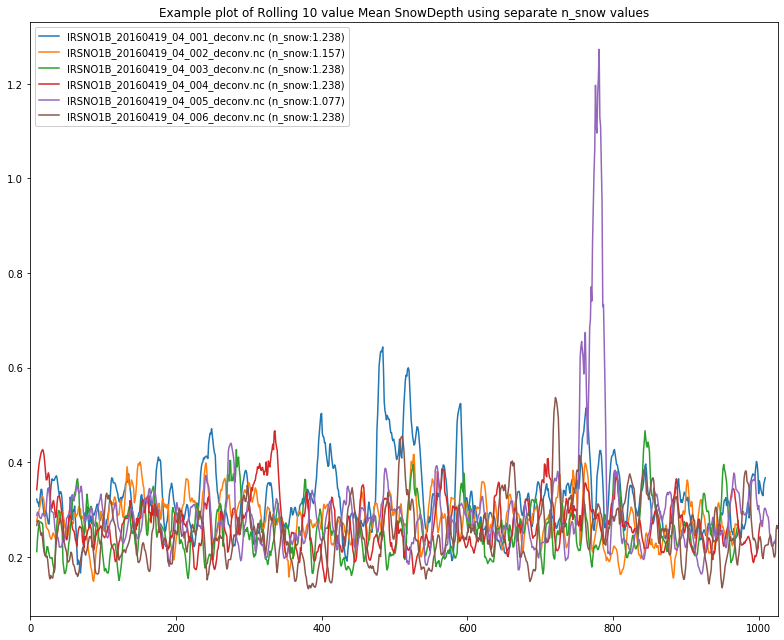

In [9]:
fig, ax = plt.subplots(figsize=(11,9))
for srcfile in df.src.unique():
    data = df.loc[df.src == srcfile, ['n_snow', 'snow_depth']]
    label = '{f} (n_snow:{sd:.3f})'.format(f=srcfile, sd=data.n_snow.unique()[0])
    data['snow_depth'].rolling(10).mean().plot(ax=ax, label=label)
ax.set_title('Example plot of Rolling 10 value Mean SnowDepth using separate n_snow values')
ax.legend(loc=0,framealpha=1)
fig.tight_layout();